<a href="https://colab.research.google.com/github/meetptl04/pretox-classifier/blob/main/NLP_BioBert_PRETOX_REL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade numpy==1.26.0

In [2]:
%pip install datasets nltk scikit-learn transformers torch spacy scispacy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [3]:
import nltk
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np

In [6]:
nltk.download('punkt')
nltk.download('punkt_tab')

def preprocess_text(text):
    tokens = nltk.word_tokenize(str(text).lower())
    return ' '.join(tokens)

train_df = pd.read_csv("/content/train_ds.csv")
valid_df = pd.read_csv("/content/validation_ds.csv")
test_df  = pd.read_csv("/content/test_ds.csv")

for df in [train_df, valid_df, test_df]:
    df["label"] = df["label"].map({"PRETOX_REL": 1, "NO_PRETOX_REL": 0})
    df["processed_text"] = df["text"].apply(preprocess_text)

x_train, y_train = train_df["processed_text"], train_df["label"]
x_valid, y_valid = valid_df["processed_text"], valid_df["label"]
x_test, y_test   = test_df["processed_text"],  test_df["label"]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [7]:
x_train.head(5) , y_train.head(5)

(0    at 3 mg / kg , a pronounced decrease of termin...
 1    the main finding was atrophy of epithelium in ...
 2    _ the evaluation of blood pressure and of hear...
 3          no relevant changes were found in females .
 4    adverse treatment - related effects were limit...
 Name: processed_text, dtype: object,
 0    1
 1    1
 2    0
 3    0
 4    1
 Name: label, dtype: int64)

In [8]:
# Load BioBERT tokenizer and model
model_name = "dmis-lab/biobert-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [13]:
# Tokenize datasets
train_encodings = tokenizer(
    x_train.tolist(),
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt"
)

valid_encodings = tokenizer(
    x_valid.tolist(),
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt"
)

test_encodings = tokenizer(
    x_test.tolist(),
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt"
)

In [14]:
# Convert labels to tensors
train_labels = torch.tensor(y_train.tolist())
valid_labels = torch.tensor(y_valid.tolist())
test_labels  = torch.tensor(y_test.tolist())

# Create TensorDatasets
train_dataset = TensorDataset(
    train_encodings["input_ids"],
    train_encodings["attention_mask"],
    train_labels
)

valid_dataset = TensorDataset(
    valid_encodings["input_ids"],
    valid_encodings["attention_mask"],
    valid_labels
)

test_dataset = TensorDataset(
    test_encodings["input_ids"],
    test_encodings["attention_mask"],
    test_labels
)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=8)
test_dataloader  = DataLoader(test_dataset, batch_size=8)

In [15]:
# Set up optimizer (AdamW from torch)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Learning rate scheduler (decays LR every epoch)
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

# Loss function for binary classification
loss_fn = torch.nn.CrossEntropyLoss()

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set up mixed precision training
scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

/tmp/ipython-input-4024496607.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None



Epoch 1/10
Train Loss: 0.2230 | Train Acc: 0.9089
Val Loss: 0.0926 | Val Acc: 0.9727
Model improved — saved.

Epoch 2/10
Train Loss: 0.0881 | Train Acc: 0.9708
Val Loss: 0.1084 | Val Acc: 0.9636
No improvement for 1 epoch(s)

Epoch 3/10
Train Loss: 0.0412 | Train Acc: 0.9903
Val Loss: 0.1311 | Val Acc: 0.9500
No improvement for 2 epoch(s)

Epoch 4/10
Train Loss: 0.0569 | Train Acc: 0.9839
Val Loss: 0.1397 | Val Acc: 0.9614
No improvement for 3 epoch(s)

Epoch 5/10
Train Loss: 0.0160 | Train Acc: 0.9937
Val Loss: 0.1615 | Val Acc: 0.9659
No improvement for 4 epoch(s)

Epoch 6/10
Train Loss: 0.0014 | Train Acc: 1.0000
Val Loss: 0.1742 | Val Acc: 0.9659
No improvement for 5 epoch(s)
Early stopping.

Final Test Accuracy: 0.9409

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       248
           1       0.91      0.96      0.93       192

    accuracy                           0.94       440
   macro avg       0.94

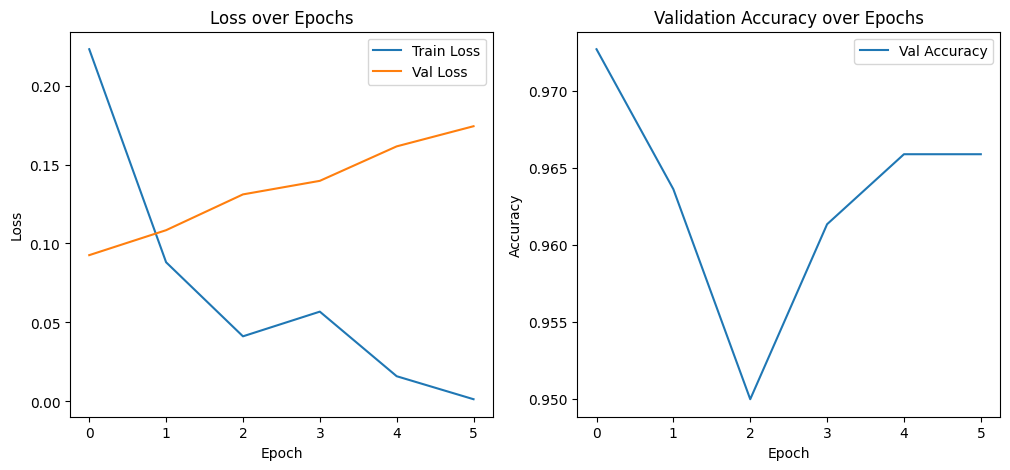

In [17]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

epochs = 10
patience = 5
best_val_acc = 0.0
epochs_no_improve = 0

train_losses = []
val_losses = []
val_accuracies = []

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = [t.to(device) for t in batch]
        optimizer.zero_grad()

        # Mixed precision
        if scaler:
            with torch.amp.autocast('cuda'):
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct / total
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in valid_dataloader:
            input_ids, attention_mask, labels = [t.to(device) for t in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(valid_dataloader)
    val_accuracy = val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step(val_accuracy)

    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

    # Early Stopping
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Model improved — saved.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s)")
        if epochs_no_improve >= patience:
            print("Early stopping.")
            break

model.load_state_dict(torch.load("best_model.pth"))
model.eval()

test_correct = 0
test_total = 0
test_preds = []
test_labels_list = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = [t.to(device) for t in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)
        test_preds.extend(preds.cpu().numpy())
        test_labels_list.extend(labels.cpu().numpy())

test_accuracy = test_correct / test_total
print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
from sklearn.metrics import classification_report
print(classification_report(test_labels_list, test_preds))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over Epochs")

plt.subplot(1,2,2)
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy over Epochs")

plt.show()

In [18]:
# Final evaluation on test set
model.eval()
test_preds, test_labels_list = [], []
with torch.no_grad():
    for batch in test_dataloader:
        batch_input_ids, batch_attention_mask, batch_labels = [x.to(device) for x in batch]
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        logits = outputs.logits
        test_preds.extend(torch.argmax(logits, dim=1).tolist())
        test_labels_list.extend(batch_labels.tolist())

test_acc = accuracy_score(test_labels_list, test_preds)
print(f"Test Accuracy: {test_acc:.4f}")
print(classification_report(test_labels_list, test_preds))

Test Accuracy: 0.9409
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       248
           1       0.91      0.96      0.93       192

    accuracy                           0.94       440
   macro avg       0.94      0.94      0.94       440
weighted avg       0.94      0.94      0.94       440



In [19]:
from google.colab import files

# Download the saved model
files.download("best_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
# Load Saved Model
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()

# Prediction
def predict(text_list):
    processed_texts = [preprocess_text(text) for text in text_list]
    encodings = tokenizer(
        processed_texts,
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt"
    )

    input_ids = encodings["input_ids"].to(device)
    attention_mask = encodings["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

    return preds.cpu().tolist()

label_map = {0: "NO_PRETOX_REL", 1: "PRETOX_REL"}

while True:
    sentence = input("Enter a sentence (type 'exit' to quit): ")
    if sentence.lower() == "exit":
        print("Exiting...")
        break

    prediction = predict([sentence])[0]
    print(f"Prediction: {label_map[prediction]}\n")

Enter a sentence (type 'exit' to quit): Patient shows signs of pretreatment toxicity.
Prediction: PRETOX_REL

Enter a sentence (type 'exit' to quit): No relevant pretreatment toxicity observed.
Prediction: NO_PRETOX_REL

Enter a sentence (type 'exit' to quit): exit
Exiting...
